## Quiz #0801

### "Text Classification with Keras"

In [74]:
import numpy as np
import pandas as pd
import re
import nltk
import os
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Embedding, SpatialDropout1D, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.preprocessing.text import Tokenizer


#nltk.download('stopwords')

#### Answer the following question by providing Python code:

1). Read in the movie review data from Cornell CS department. Carry out the EDA. <br>
- The data can be found [here](https://www.cs.cornell.edu/people/pabo/movie-review-data). <br>
- Download the “polarity dataset” and unzip. <br>
- Under the "txt_sentoken” folder, there are “pos” and “neg" subfolders. <br>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive') # You can either use your drive or work directly on colab with temporary import

Mounted at /content/gdrive


In [3]:
# Specify the folder and read in the subfolders.
reviews = load_files('/content/gdrive/My Drive/Colab Notebooks/Chapter 08/txt_sentoken/') # Colabs
# reviews = load_files('txt_sentoken/')   # Offline
my_docs, y = reviews.data, reviews.target

In [4]:
my_docs[0]

b"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \r\nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \r\nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \r\nin this so called dark thriller , the devil ( gabriel byrne ) has come upon earth , to impregnate a woman ( robin tunney ) which happens every 1000 years , and basically destroy the world , but apparently god has chosen one man , and that one man is jericho cane ( arnold himself ) . \r\nwith the help of a trusty sidekick ( kevin pollack ) , they will stop at nothing to let the devil take over the world ! \r\nparts of this are actually so absurd , that they would fit right in with dogma . \r\nyes , 

2). Carry out the data preprocessing: <br>
- Cleaning.
- Stopword removal.

In [26]:
nltk.download("stopwords")
nltk.download("english")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading english: Package 'english' not found in
[nltk_data]     index
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
def cleantxt(txt):
    """
    Cleaning Includes:
    1. remove special characters/symbols
    2. convert text to lower-case
    3. retain only alphabets
    4. remove words less than 3 characters
    5. remove stop-words
    """  
    stpw = stopwords.words('english')
    
    # Adding custom stop-words
    stpw = set(stpw)
    

    # using regex to clean the text
    txt = re.sub(r"\n", " ", txt)
    txt = re.sub("[\<\[].*?[\>\]]", " ", txt)
    txt = txt.lower()
    txt = re.sub(r"[^a-z ]", " ", txt)
    txt = re.sub(r"\b\w{1,3}\b", " ",txt)
    txt = re.sub(r'\s+',' ',txt)
    txt = " ".join([x for x in txt.split() if x not in stpw])
    return txt

# Cleaning text
my_docs = [doc.decode('utf-8') for doc in my_docs]
my_docs_cleaned = list(map(lambda x: cleantxt(x), my_docs))

In [100]:
my_docs_cleaned[0]

'arnold schwarzenegger icon action enthusiasts since late lately films sloppy liners getting worse hard seeing arnold freeze batman robin especially says tons jokes million matter arnold signed another expensive blockbuster compare likes terminator series true lies even eraser called dark thriller devil gabriel byrne come upon earth impregnate woman robin tunney happens every years basically destroy world apparently chosen jericho cane arnold help trusty sidekick kevin pollack stop nothing devil take world parts actually absurd would right dogma film weak better blockbuster right sleepy hollow makes world enough look like star film anyway definitely seem like arnold movie type film sure gave chuckles well known liners seemed confused character film going understandable especially ending changed according sources aside form still walked much like past films sorry arnold maybe action days speaking action film hardly explosions fights devil made places explode arnold kicking devil butt en

3). Carry out label encoding by integers (required form by Keras):

In [27]:
max_len = 0

for doc in my_docs_cleaned:
  sentences = nltk.sent_tokenize(doc)
  m = max([len(sentence.split(" ")) for sentence in sentences])
  if m > max_len: max_len = m


In [28]:
max_len

1290

In [165]:
MAX_NB_WORDS = 50000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250

EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(my_docs_cleaned)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 37556 unique tokens.


4). Prepare the data for AI: <br>
- Apply the padding.
- Split the data into training and testing.

In [166]:
np.unique(y, return_counts=True)

(array([0, 1]), array([1000, 1000]))

In [167]:
X = tokenizer.texts_to_sequences(my_docs_cleaned)#list of integers
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH) #padding
print('Shape of data tensor:', X.shape)

labels = np.unique(y)
Y = y.reshape(-1, 1)
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (2000, 250)
Shape of label tensor: (2000, 1)


In [168]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=123, shuffle=True)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1600, 250) (1600, 1)
(400, 250) (400, 1)


5). Define the AI model (Embedding + LSTM):

In [170]:
# Code Here
model = Sequential([
        Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]),
        SpatialDropout1D(0.2),
        LSTM(100, dropout=0.2, recurrent_dropout=0.2, recurrent_activation="sigmoid"),
        Dense(Y.shape[1], activation='sigmoid')
    ], name="Toxic_Complaint_Classifier")

print(model.summary())

Model: "Toxic_Complaint_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 250, 150)          7500000   
_________________________________________________________________
spatial_dropout1d_29 (Spatia (None, 250, 150)          0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 100)               100400    
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 101       
Total params: 7,600,501
Trainable params: 7,600,501
Non-trainable params: 0
_________________________________________________________________
None


6). Define the optimizer and compile the model:

In [171]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])


7). Train the model and visualize the summary:

In [172]:
!nvidia-smi

Thu Sep  2 12:28:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    74W / 149W |   1778MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [173]:
mcp_save = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Chapter 08/best_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')
early_stp = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

In [174]:
epochs = 5
batch_size = 64
# Code Here
import tensorflow as tf
# with tf.device("/GPU:0"): # offline
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[early_stp, mcp_save])

Epoch 1/5
23/23 [==============================] - 40s 2s/step - loss: 0.6921 - accuracy: 0.5222 - val_loss: 0.6824 - val_accuracy: 0.6750
Epoch 2/5
23/23 [==============================] - 37s 2s/step - loss: 0.5960 - accuracy: 0.8042 - val_loss: 0.5763 - val_accuracy: 0.7000
Epoch 3/5
23/23 [==============================] - 37s 2s/step - loss: 0.3496 - accuracy: 0.9222 - val_loss: 0.4755 - val_accuracy: 0.7563
Epoch 4/5
23/23 [==============================] - 37s 2s/step - loss: 0.0853 - accuracy: 0.9750 - val_loss: 0.5689 - val_accuracy: 0.7437
Epoch 5/5
23/23 [==============================] - 36s 2s/step - loss: 0.0386 - accuracy: 0.9910 - val_loss: 0.5120 - val_accuracy: 0.8313


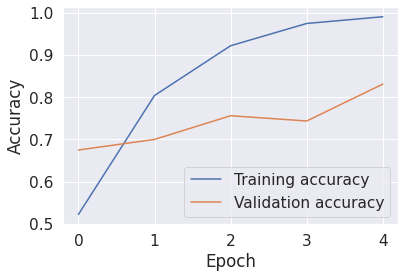

In [175]:
train_accuracy = history.history["accuracy"]
validation_accuracy = history.history["val_accuracy"]
count = range(len(train_accuracy))

train_loss = history.history["loss"]
plt.plot(count, train_accuracy, label='Training accuracy')
plt.plot(count, validation_accuracy, label='Validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

8). Display the test result (accuracy):

In [176]:
Y_pred = model.predict(X_test)

In [177]:
predicted_classes = np.array([0 if x < 0.5 else 1 for x in Y_pred])
expected_classes = Y_test

In [178]:
Y_test.shape, predicted_classes.shape

((400, 1), (400,))

In [179]:
score = model.evaluate(Y_test,predicted_classes)
print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}'.format(score[0], accuracy_score(expected_classes, predicted_classes)))

13/13 [==============================] - 0s 3ms/step - loss: 0.6964 - accuracy: 0.4275
Test set
  Loss: 0.70
  Accuracy: 0.84


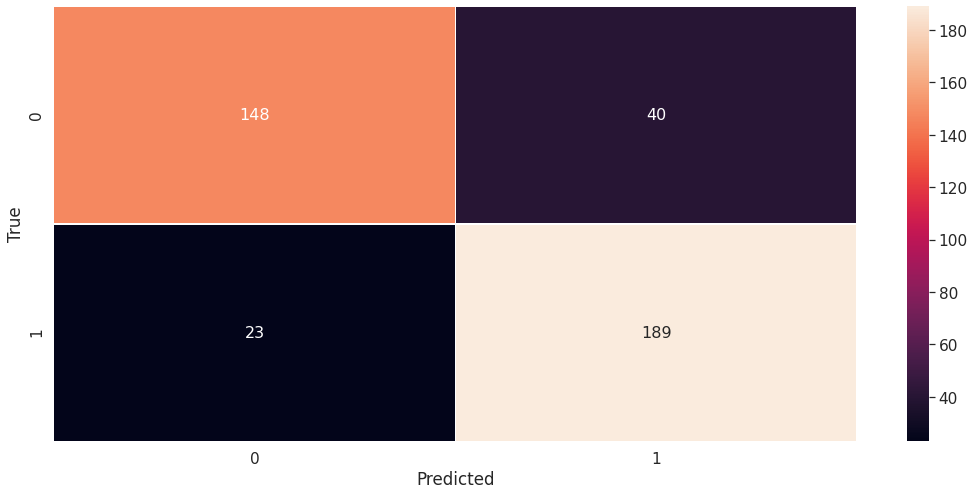

In [180]:
cm = confusion_matrix(expected_classes, predicted_classes)
plt.figure(figsize=(18,8))
sns.set(font_scale=1.4) 
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='d',linewidths=0.5, xticklabels=labels, yticklabels=labels) 
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()